In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
plt.style.use('bmh')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
from IPython.core.display import display, HTML
pylab.rcParams.update(params)
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lars
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import statsmodels.api as sm
import statsmodels.api 

In [37]:
df = pd.read_csv("ml_dataset.csv")
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df.shape

(2366, 110)

In [38]:
to_stationary = ['S&P_Open', 'S&P_High', 'S&P_Low', 'S&P_Close', 'S&P_Volume', 'CO_Close', 'RBOB_f__Open', 'RBOB_f__High', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_f__Volume', 'RBOB_f__OpenInt', 'RBOB_minus_CO']

### Adding stationary variables

In [39]:
df_stationary = df.copy()
df_stationary = df_stationary[to_stationary].diff()
df_stationary.dropna(inplace = True)
df_stationary = df_stationary.add_prefix("Stationary_")
df = pd.merge(df,df_stationary,left_index=True,right_index=True,how="inner")
df.shape

(2365, 123)

In [40]:
df_train_val = df[df.index<="2018-11-29"]
df_test = df[df.index>"2018-11-29"]
df_train = df_train_val[df_train_val.index<="2017-11-29"]
df_val = df_train_val[df_train_val.index>"2017-11-29"]

### SVR preparations

In [41]:
variables = df_train.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'
print(len(features))

122


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


RMSE:  0.03340810179533159


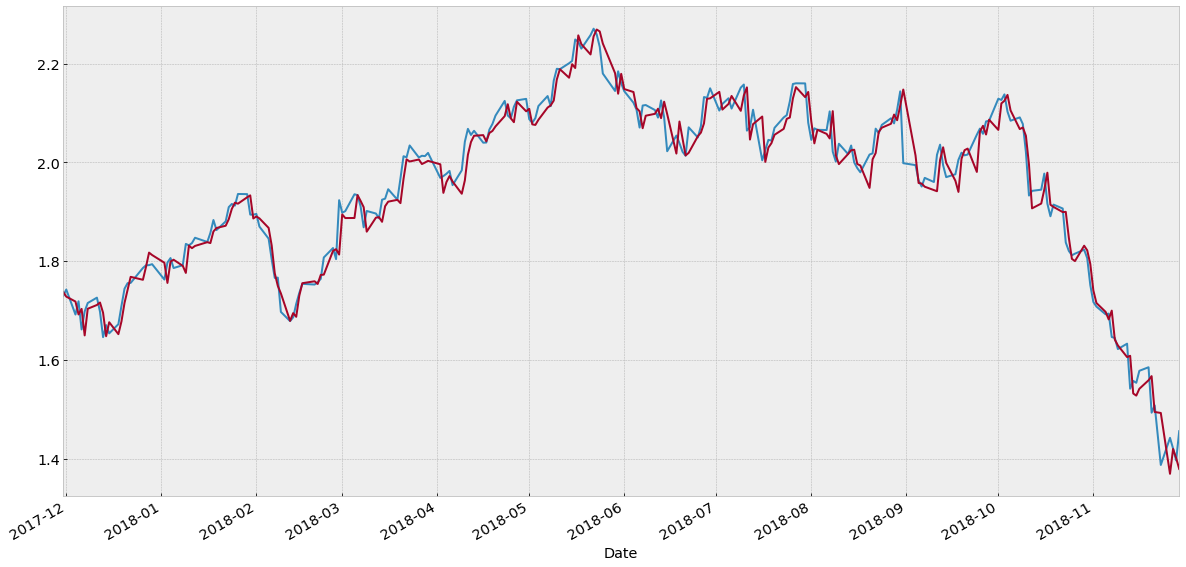

In [53]:
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear',C=10, epsilon=0.01)


model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))


### RFE 

['month', 'CO_Close', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_minus_CO', 'y_shif1', 'rolling_mean_2days', 'rolling_mean_3days', 'RBOB_f_EMA', 'RBOB_f_SMA']


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSE:  0.03322015067359712


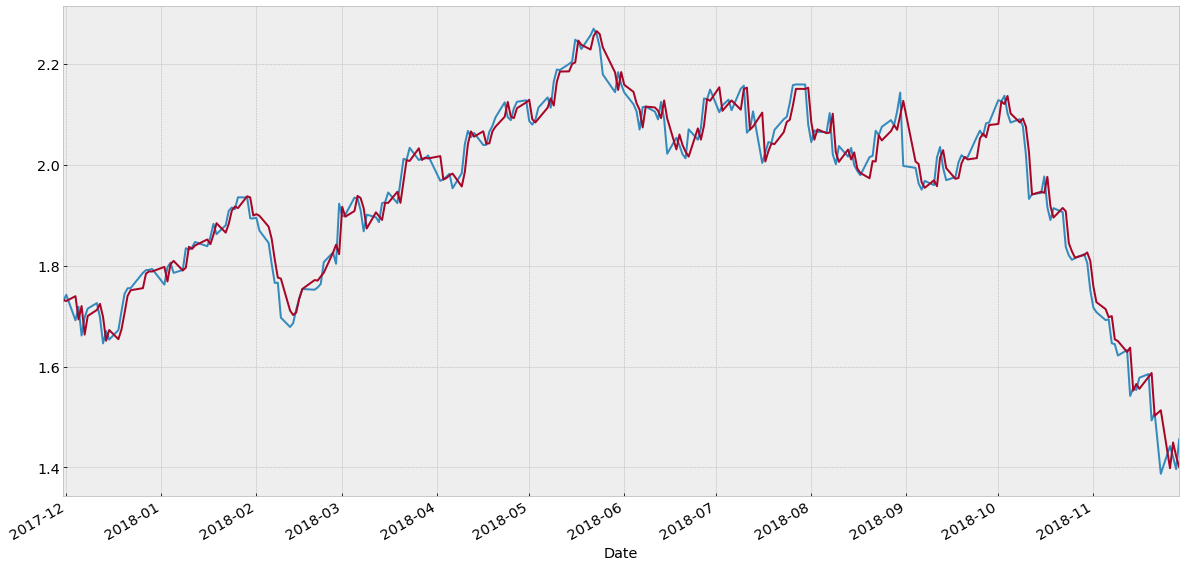

In [54]:
variables = df_train.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'

sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')
selector = RFE(model,n_features_to_select=10)
selector = selector.fit(scaled_features,scaled_target)
res = selector.support_
dF = pd.DataFrame()
dF["col"] = df_train[features].columns.tolist()
dF["res"] = res
best_features_from_rfe = dF[dF.res == True].col.tolist()
print(best_features_from_rfe)
KK = best_features_from_rfe

variables = KK.copy()
features = df_train[variables].columns
target = 'y'
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')

model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))

['day_of_year', 'month', 'CO_Close', 'RBOB_f__High', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_minus_CO', 'y_shif1', 'y_shif2', 'y_shif5', 'rolling_mean_week', 'rolling_mean_2days', 'rolling_mean_3days', 'RSI', 'RBOB_f_DEMA', 'RBOB_f_EMA', 'RBOB_f_MA', 'RBOB_f_SMA', 'RBOB_f_T3', 'RBOB_f_TEMA']


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSE:  0.033347015361695535


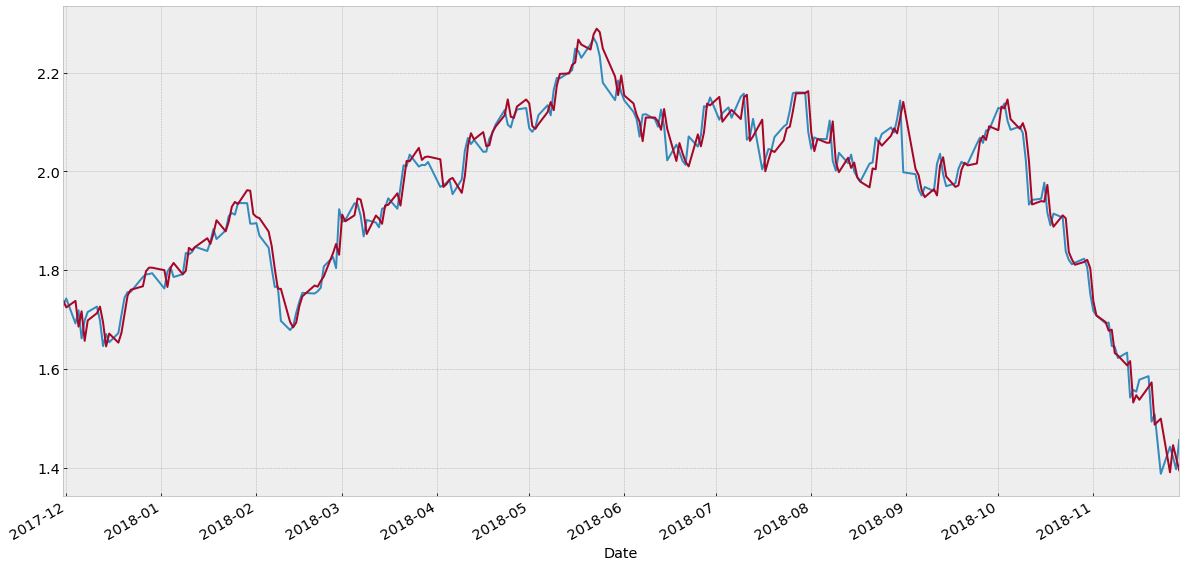

In [55]:
variables = df_train.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'

sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')
selector = RFE(model,n_features_to_select=20)
selector = selector.fit(scaled_features,scaled_target)
res = selector.support_
dF = pd.DataFrame()
dF["col"] = df_train[features].columns.tolist()
dF["res"] = res
best_features_from_rfe = dF[dF.res == True].col.tolist()
print(best_features_from_rfe)
KK = best_features_from_rfe

variables = KK.copy()
features = df_train[variables].columns
target = 'y'
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')

model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))

['day_of_year', 'month', 'CO_Close', 'RBOB_f__Open', 'RBOB_f__High', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_f__OpenInt', 'RBOB_minus_CO', 'y_shif1', 'y_shif2', 'y_shif3', 'y_shif5', 'rolling_mean_week', 'rolling_mean_month', 'rolling_mean_2days', 'rolling_mean_3days', 'rolling_std_week', 'rolling_std_3days', 'RSI', 'RBOB_f_DEMA', 'RBOB_f_EMA', 'RBOB_f_MA', 'RBOB_f_SMA', 'RBOB_f_T3', 'RBOB_f_TEMA', 'RBOB_f_TRIMA', 'Stationary_CO_Close', 'Stationary_RBOB_f__Close', 'Stationary_RBOB_minus_CO']


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSE:  0.03496597975013611


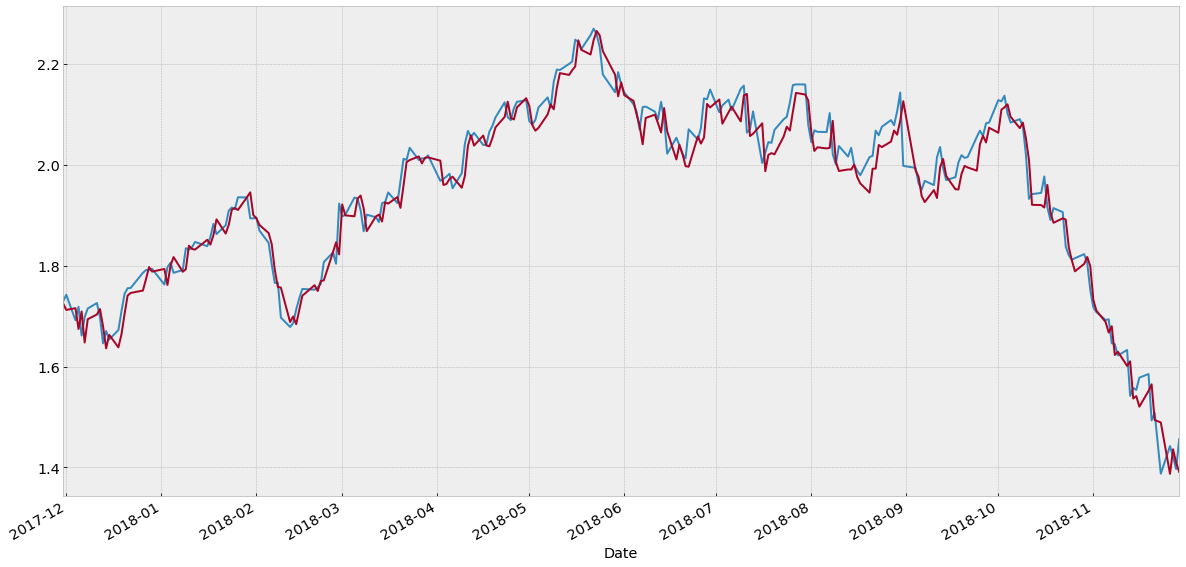

In [56]:
variables = df_train.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'

sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')
selector = RFE(model,n_features_to_select=30)
selector = selector.fit(scaled_features,scaled_target)
res = selector.support_
dF = pd.DataFrame()
dF["col"] = df_train[features].columns.tolist()
dF["res"] = res
best_features_from_rfe = dF[dF.res == True].col.tolist()
print(best_features_from_rfe)
KK = best_features_from_rfe

variables = KK.copy()
features = df_train[variables].columns
target = 'y'
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')

model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))

['day_of_year', 'month', 'S&P_Open', 'S&P_Low', 'CO_Close', 'RBOB_f__Open', 'RBOB_f__High', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_f__OpenInt', 'RBOB_minus_CO', 'y_shif1', 'y_shif2', 'y_shif3', 'y_shif5', 'rolling_mean_week', 'rolling_mean_month', 'rolling_mean_2days', 'rolling_mean_3days', 'rolling_std_week', 'rolling_std_3days', 'rolling_std_2days', 'RBOB_f_CDLHANGINGMAN', 'RBOB_f_CDLMARUBOZU', 'RSI', 'RBOB_f_DEMA', 'RBOB_f_EMA', 'RBOB_f_KAMA', 'RBOB_f_MA', 'RBOB_f_SMA', 'RBOB_f_T3', 'RBOB_f_TEMA', 'RBOB_f_TRIMA', 'Stationary_CO_Close', 'Stationary_RBOB_f__Open', 'Stationary_RBOB_f__High', 'Stationary_RBOB_f__Low', 'Stationary_RBOB_f__Close', 'Stationary_RBOB_f__Volume', 'Stationary_RBOB_minus_CO']


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSE:  0.03690770892515686


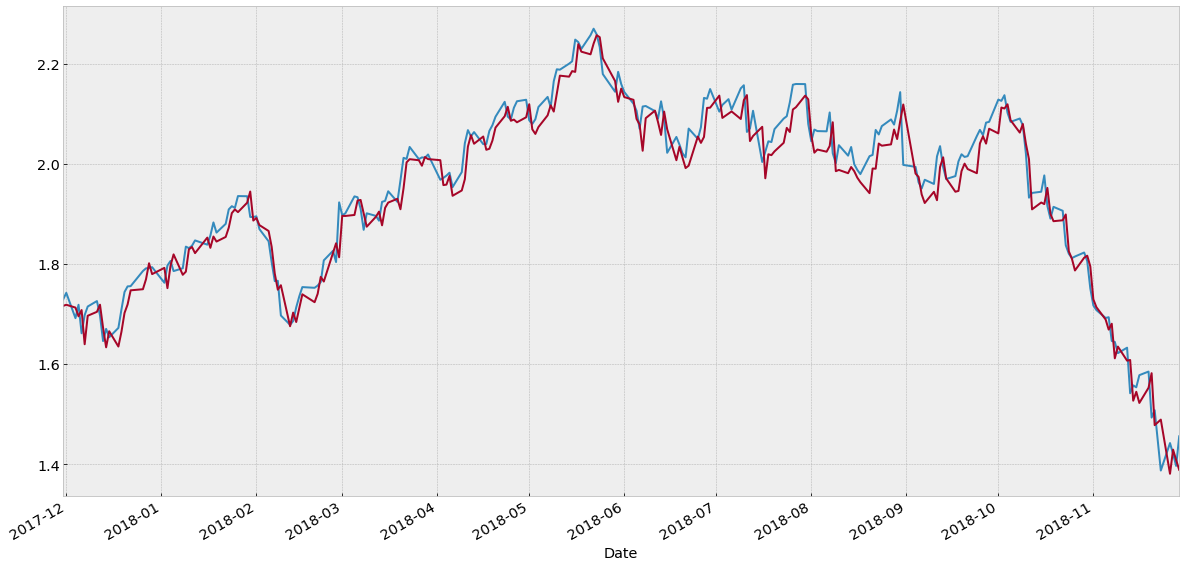

In [57]:
variables = df_train.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'

sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')
selector = RFE(model,n_features_to_select=40)
selector = selector.fit(scaled_features,scaled_target)
res = selector.support_
dF = pd.DataFrame()
dF["col"] = df_train[features].columns.tolist()
dF["res"] = res
best_features_from_rfe = dF[dF.res == True].col.tolist()
print(best_features_from_rfe)
KK = best_features_from_rfe

variables = KK.copy()
features = df_train[variables].columns
target = 'y'
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')

model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))

### Additional adjustments like: correlation treshold and etc.

3
RMSE:  0.033472052702818784


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


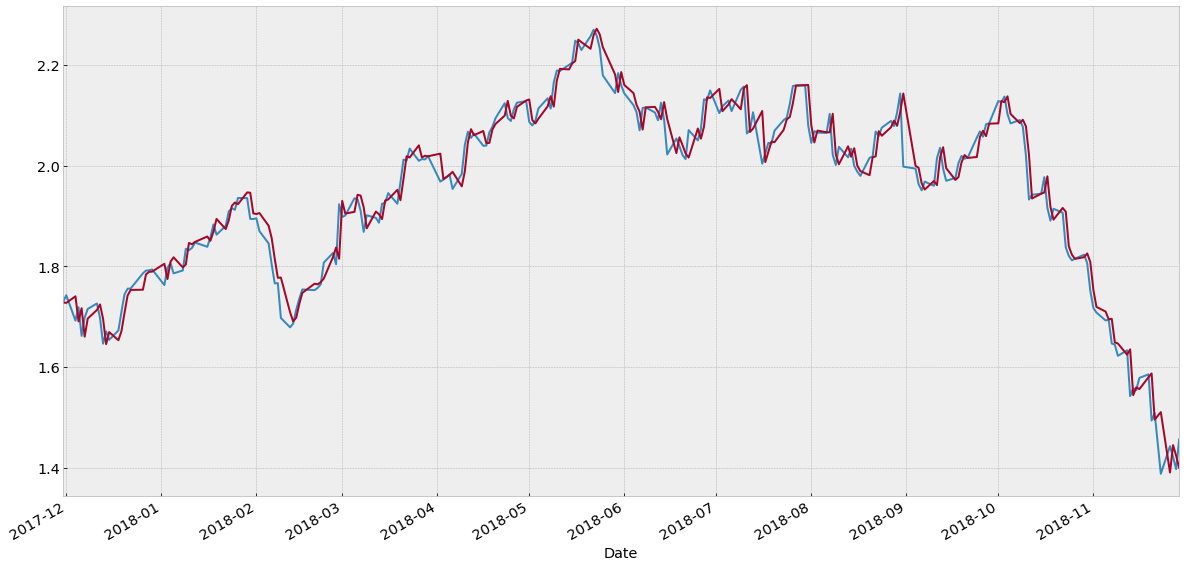

In [59]:
xxx = ['month', 'CO_Close', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_minus_CO', 'y_shif1', 'rolling_mean_2days', 'rolling_mean_3days', 'RBOB_f_EMA', 'RBOB_f_SMA']


# Create correlation matrix
corr_matrix = df_train[xxx].corr("spearman").abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

final_list = list(set(xxx)-set(to_drop))

print(len(final_list))

variables = final_list.copy()
features = df_train[variables].columns
target = 'y'
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear')

model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))

In [60]:
variables = df_train.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'
print(len(features))

122


C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


RMSE:  0.03328924861207762


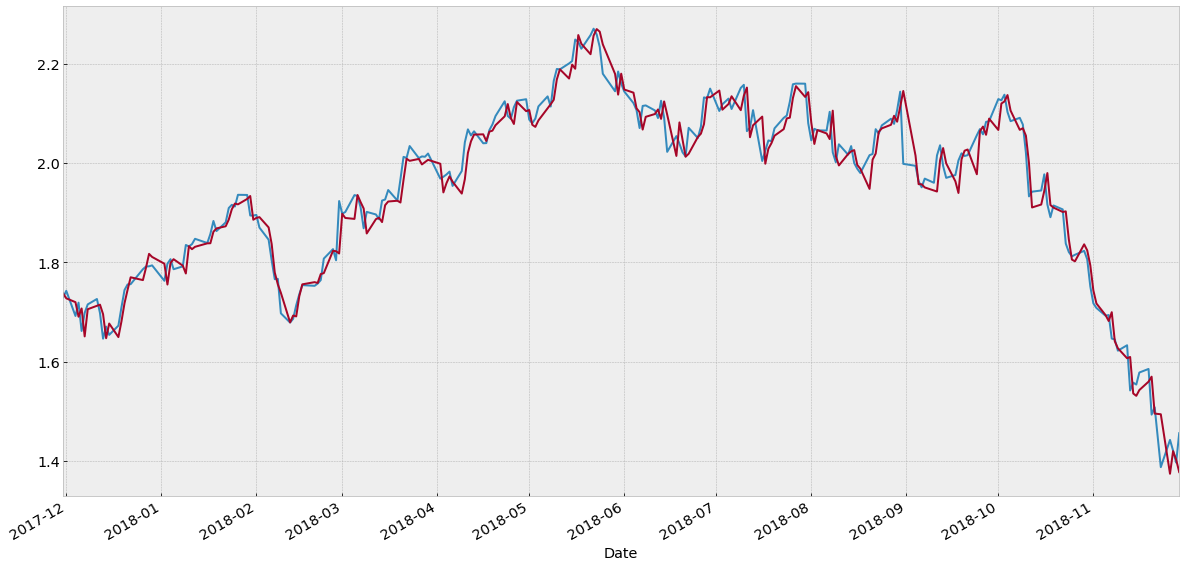

In [75]:
sf = StandardScaler()
st = StandardScaler()
scaled_features = sf.fit_transform(df_train[features].values)
scaled_target = st.fit_transform((df_train[target].values).reshape(-1,1))
scaled_target = scaled_target.ravel()
model = SVR(kernel='linear',C=2,epsilon=0.01)

model.fit(scaled_features,scaled_target)
preds = st.inverse_transform(model.predict(sf.transform(df_val[features])))
dF = df_val
dF["y_hat"] = preds
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))


### Hyperparameters tunning

In [76]:
DFparameters = pd.DataFrame()

In [80]:
best_features = ['month', 'CO_Close', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_minus_CO', 'y_shif1', 'rolling_mean_2days', 'rolling_mean_3days', 'RBOB_f_EMA', 'RBOB_f_SMA','y']

In [82]:
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.metrics import mean_squared_error

for x in range(20):
    params = [random.uniform(1,3), random.uniform(0.01,0.1)]
    
    df_train_temp = df_train[best_features].copy()
    df_val_temp = df_val.copy()

    features = df_train_temp.columns.tolist()
    features.remove("y")
    target = 'y'
        
    model = SVR(kernel='linear', C=params[0], epsilon=params[1])
           
    y_hat = list()

    for i in range(len(df_val_temp)):    
        df_validating = df_val_temp[df_val_temp.index == df_val_temp.index[i]]
        
        sf = StandardScaler()
        st = StandardScaler()
        scaled_features = sf.fit_transform(df_train_temp[features].values)
        scaled_target = st.fit_transform((df_train_temp[target].values).reshape(-1,1))
        scaled_target = scaled_target.ravel()
        
        model.fit(scaled_features,scaled_target)
        preds = st.inverse_transform(model.predict(sf.transform(df_validating[features])))

        df_train_temp = df_train_temp.append(df_validating)
        y_hat.append(preds[0])
     
    rmse = np.sqrt(mean_squared_error(df_val_temp[target], y_hat))
    
    params.append(rmse)

    row = pd.Series(params)
    DFparameters = DFparameters.append([row], ignore_index=True)
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [83]:
temp = DFparameters.copy()
temp.sort_values(by=2,inplace=True)
temp

,0,1,2
11,1.547544,0.096128,0.033152
3,1.112304,0.086021,0.033188
12,1.579490,0.086094,0.033196
7,2.897660,0.094823,0.033197
16,1.549890,0.094327,0.033202
8,2.279673,0.081293,0.033205
10,1.816806,0.091288,0.033221
15,2.624929,0.050993,0.033272
17,2.530172,0.014299,0.033296
6,2.088257,0.040747,0.033299


In [84]:
df_train_temp = df_train[best_features].copy()
df_val_temp = df_val.copy()

features = df_train_temp.columns.tolist()
features.remove("y")
target = 'y'
    
params = [1.547544,0.096128]
    
model = SVR(kernel='linear', C=params[0], epsilon=params[1])

                         
y_hat = list()

for i in range(len(df_val_temp)):    
    df_validating = df_val_temp[df_val_temp.index == df_val_temp.index[i]]
        
    sf = StandardScaler()
    st = StandardScaler()
    scaled_features = sf.fit_transform(df_train_temp[features].values)
    scaled_target = st.fit_transform((df_train_temp[target].values).reshape(-1,1))
    scaled_target = scaled_target.ravel()
        
    model.fit(scaled_features,scaled_target)
    preds = st.inverse_transform(model.predict(sf.transform(df_validating[features])))

    df_train_temp = df_train_temp.append(df_validating)
    y_hat.append(preds[0])
     
rmse = np.sqrt(mean_squared_error(df_val_temp[target], y_hat))
print(rmse)

0.033162193701920424


In [85]:
from sklearn.metrics import *

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adj_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+y_pred))) * 100

def metryczki(x,y):
    wyniki = pd.DataFrame()
    mae = mean_absolute_error(x,y)
    xd = list()
    xd.append(mae)
    mse = mean_squared_error(x,y)
    rmse = np.sqrt(mean_squared_error(x,y))
    mape = mean_absolute_percentage_error(x,y)
    amape = adj_mean_absolute_percentage_error(x,y)
    wyniki["MAE"]=xd
    wyniki["MSE"]=mse
    wyniki["RMSE"]=rmse
    wyniki["MAPE"]=mape
    wyniki["AMAPE"]=amape
    return wyniki

In [86]:
metryczki(df_val_temp[target], y_hat)

,MAE,MSE,RMSE,MAPE,AMAPE
0,0.024577,0.0011,0.033162,1.29076,0.642659
